In [498]:
#@title ##imports

import tensorflow as tf
from tensorflow import keras
from sklearn import datasets
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
import numpy as np
import os
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import collections


In [499]:
#@title ##ReadData
class ReadData:
    
    def __init__(self):
        super(ReadData, self).__init__()
    def con(self,inp):
        if inp.strip()==b"true":
            return int(1)
        else:
            return int(0)
    def removeNan(self,a):
        val = []
        for idx,value in enumerate(a):
            array_sum = np.sum(value)
            array_has_nan = np.isnan(array_sum)
            if array_has_nan:
                val.append(idx)
        a = np.delete(a,(val),0)
        return a

    def getRawData(self,csvFileName):
        data = np.empty((0,22),float) 
        print("inside raw data")
        print(data.shape)  
        for f in csvFileName:
            array = np.genfromtxt(f, delimiter=",", skip_header=1,converters={-1:self.con})
            data = np.append(data,array,axis = 0)
        print(data.shape) 
        data = self.removeNan(data)
        print(data.shape)
        np.random.shuffle(data)
        return data


In [500]:
#@title ##Preprocess Data
class PreprocessData(object):

    """docstring for PreprocessData"""
    def __init__(self):
        super(PreprocessData, self).__init__()
    
    def normalise(self,rawData):
        scaler = MinMaxScaler()
        data = scaler.fit_transform(rawData[:,:])
        return data

    def seprateFeatLabel(self,rawData):
        features = rawData[:,:-1]
        labels = rawData[:,-1]
        return features,labels



In [501]:
#@title ##Build Model
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.85
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))






class BuildModel(object):

    """docstring for BuildModel"""
    def __init__(self,features,classes,activation,samples,loss = 'cosine_similarity'):
        
        super(BuildModel, self).__init__()
        self.loss = loss
        self.features = features
        self.classes = classes
        self.activation = activation
        self.samples = samples
    
    
    def BuildAttentionGRU(self):
        attention = Attention(20)
        input_layer = tf.keras.Input(shape=(self.features,1), dtype='float32')
        gru,hidden = tf.keras.layers.GRU(21,return_sequences=True, return_state=True)(input_layer)
        context_vector, attention_weights = attention(hidden,gru)
        hidden = tf.keras.layers.Dense(10)(context_vector)
        output = tf.keras.layers.Dense(self.classes, activation= self.activation)(hidden)
        model = tf.keras.Model(inputs = input_layer,outputs = output,name = "AttentionGRU")
        model.compile(loss = focal_loss,optimizer = 'adam',metrics=['accuracy'])
        return model

    def BuildCNN(self):
        
        CNNInputShape = (self.features/3,3,1)
    
        model = tf.keras.Sequential([tf.keras.layers.Conv2D(10,(2,2),input_shape = CNNInputShape),
                                    tf.keras.layers.Conv2D(10,(2,2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(10),
                                    tf.keras.layers.Dense(self.classes,activation = self.activation)],name = "CNN")
    
    
        model.compile(loss = self.loss,optimizer = 'adam',metrics=['accuracy'])
        return model


    def BuildMLP(self):
        
        model = tf.keras.Sequential([tf.keras.layers.Dense(20,input_shape = (self.features,)),
                                 tf.keras.layers.Dense(10),
                                 tf.keras.layers.Dense(self.classes,activation = self.activation)],name = "MLP")
        model.compile(loss = self.loss,optimizer = 'adam',metrics=['accuracy'])
        return model

    def BuildRNN(self):
        
        model = tf.keras.Sequential([tf.keras.layers.SimpleRNN(self.features,input_shape = (self.features,1)),
                                     tf.keras.layers.Dense(10),
                                     tf.keras.layers.Dense(self.classes,activation = self.activation)])
        model.compile(loss = self.loss,optimizer = 'adam',metrics=['accuracy'],name = "RNN")
        return model

    def BuildGRU(self):
        gruInput = (self.features,1)
        model = tf.keras.Sequential([tf.keras.layers.GRU(self.features,input_shape = gruInput),
                                     tf.keras.layers.Dense(10),
                                     tf.keras.layers.Dense(self.classes,activation= self.activation)],name = "GRU")
        model.compile(loss = self.loss,optimizer = 'adam',metrics=['accuracy'])
        return model

    def BuildLSTM(self):
        lstmInput = (self.features,1)
        model = tf.keras.Sequential([tf.keras.layers.LSTM(21, input_shape = lstmInput),
                                     tf.keras.layers.Dense(self.classes,activation = self.activation)],name = "LSTM")
        model.compile(loss = self.loss ,optimizer = 'adam',metrics=['accuracy'])
        return model



In [502]:
#@title ##Feed Model
class FeedModel(object):
    """docstring for FeedModel"""
    def __init__(self):
        super(FeedModel, self).__init__()

    def changeShape(self,model,trainData):
        
        inputshape = model.layers[0].input_shape
        if type(inputshape) == type(list()):
          inputshape = inputshape[0]
        inputshape = list(inputshape)
        inputshape[0] = trainData.shape[0]
        trainData = np.reshape(trainData,inputshape)
        return trainData

    def trainModel(self,model,trainData,trainLabel,epochs):
        trainData = self.changeShape(model,trainData)
        print("Training ",model.name)
        print(trainData.shape)
        model.fit(trainData,trainLabel,epochs = epochs)

    def predictModel(self,model,testData):
        testData = self.changeShape(model,testData)
        predictions = model.predict_proba(testData)
        return predictions
    
    def predictModelAttention(self,model,testData):
        testData = self.changeShape(model,testData)
        probabModel = tf.keras.Sequential([model,tf.keras.layers.Dense(1,activation='softmax')])
        predictions = probabModel.predict(testData)
        return predictions

    def evaluateModel(self,model,testData,testLabel,label):

      predictions = self.predictModel(model,testData)
      if(len(predictions.shape)>1):
          predictions = np.reshape(predictions,(predictions.shape[0]))
      
      auc = roc_auc_score(testLabel, predictions)
      print(auc)
      lr_fpr, lr_tpr, _ = roc_curve(testLabel, predictions)
      pyplot.plot(lr_fpr, lr_tpr, marker='.', label=label)
      # axis labels
      pyplot.xlabel('False Positive Rate')
      pyplot.ylabel('True Positive Rate')
      # show the legend
      pyplot.legend()
      # show the plot
      pyplot.show()
      return predictions
    
    def evaluateModelAttention(self,model,testData,testLabel,label):

      predictions = self.predictModelAttention(model,testData)
      if(len(predictions.shape)>1):
          predictions = np.reshape(predictions,(predictions.shape[0]))
      
      auc = roc_auc_score(testLabel, predictions)
      print(auc)
      lr_fpr, lr_tpr, _ = roc_curve(testLabel, predictions)
      pyplot.plot(lr_fpr, lr_tpr, marker='.', label=label)
      # axis labels
      pyplot.xlabel('False Positive Rate')
      pyplot.ylabel('True Positive Rate')
      # show the legend
      pyplot.legend()
      # show the plot
      pyplot.show()
      return predictions


In [503]:
#@title ##Main
epochs = 40
predictions = []
def getNasa():
    # filePath = ["PC1.csv","KC1.csv","CM1.csv"]
    filePath = ["CM1.csv"]
    rawData = ReadData().getRawData(filePath)
    x,y = PreprocessData().seprateFeatLabel(rawData)
    samples = x.shape[0]
    x = PreprocessData().normalise(x)
    return x,y,samples

def getNasaJM():
    filePath = ["JM1.csv"]
    rawData = ReadData().getRawData(filePath)
    x,y = PreprocessData().seprateFeatLabel(rawData)
    samples = x.shape[0]
    x = PreprocessData().normalise(x)
    return x,y,samples

def getSynBinaryData():
    samples = 1000
    data = datasets.make_classification(n_samples = samples,n_features = 21,n_classes = 2)
    x = data[0]
    y = data[1]
    return x,y,samples

def runMLP(b,x_train,y_train,x_val,y_val):
    global predictions 
    MLPmodel = b.BuildMLP()
    FeedModel().trainModel(MLPmodel,x_train,y_train,epochs)
    predictions = FeedModel().evaluateModel(MLPmodel,x_val,y_val,'MLP')
    return predictions

def runGRU(b,x_train,y_train,x_val,y_val):
    GRU = b.BuildGRU()
    FeedModel().trainModel(GRU,x_train,y_train,epochs)
    FeedModel().evaluateModel(GRU,x_val,y_val,'GRU')
    
def runLSTM(b,x_train,y_train,x_val,y_val):
    LSTM = b.BuildLSTM()
    FeedModel().trainModel(LSTM,x_train,y_train,epochs)
    FeedModel().evaluateModel(LSTM,x_val,y_val,'LSTM')

def runCNN(b,x_train,y_train,x_val,y_val):
    CNN = b.BuildCNN()
    FeedModel().trainModel(CNN,x_train,y_train,epochs)
    FeedModel().evaluateModel(CNN,x_val,y_val,'CNN')

def runRNN(b,x_train,y_train,x_val,y_val):
    RNN = b.BuildRNN()
    FeedModel().trainModel(RNN,x_train,y_train,epochs)
    FeedModel().evaluateModel(RNN,x_val,y_val,'RNN')

def runGRUAttention(b,x_train,y_train,x_val,y_val):
    GRUAttention = b.BuildAttentionGRU()
    FeedModel().trainModel(GRUAttention,x_train,y_train,epochs)
    FeedModel().evaluateModelAttention(GRUAttention,x_val,y_val,'GRUAttention')
    
    
    

In [504]:
def underSample(x,y,samples):
    y = np.reshape(y, (y.shape[0],1))
    data = np.concatenate((x, y), axis=1)
    c = collections.Counter(data[:,-1])
    n_delete = abs(c[0] - c[1])
    idx1 = np.where(data[:,-1] == 1)
    idx0 = np.where(data[:,-1] == 0)
    idx0 = np.array(list(idx0))
    idx1 = np.array(list(idx1))
    idx0 = np.reshape(idx0,(idx0.shape[1]))
    idx1 = np.reshape(idx1,(idx1.shape[1]))
    data = np.delete(data,(idx0[0:n_delete]),axis = 0)
    x = data[:,:-1]
    y = data[:,-1]
    return x,y,x.shape[0]

In [505]:
x,y,samples = getNasa()
x,y,samples = underSample(x,y,samples)
c = collections.Counter(y)
print(c)
x_train,x_val = train_test_split(x,test_size = 0.2)
y_train,y_val = train_test_split(y,test_size = 0.2)
b = BuildModel(features = x_train.shape[1],classes=1,activation = 'sigmoid',samples = x_train.shape[0],loss = 'binary_crossentropy')
array_sum = np.sum(x)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

inside raw data
(0, 22)
(498, 22)
(498, 22)
Counter({1.0: 49, 0.0: 49})
False


In [506]:
c_train = collections.Counter(y_train)
c_val = collections.Counter(y_val)
print(c_train)
print(c_val)

Counter({0.0: 41, 1.0: 37})
Counter({1.0: 12, 0.0: 8})


Training  MLP
(78, 21)
Train on 78 samples
Epoch 1/10
78/78 [==============================] - 1s 9ms/sample - loss: 0.6938 - accuracy: 0.5513
Epoch 2/10
78/78 [==============================] - 0s 128us/sample - loss: 0.6916 - accuracy: 0.5128
Epoch 3/10
78/78 [==============================] - 0s 153us/sample - loss: 0.6904 - accuracy: 0.5641
Epoch 4/10
78/78 [==============================] - 0s 102us/sample - loss: 0.6895 - accuracy: 0.5385
Epoch 5/10
78/78 [==============================] - 0s 102us/sample - loss: 0.6896 - accuracy: 0.5256
Epoch 6/10
78/78 [==============================] - 0s 140us/sample - loss: 0.6889 - accuracy: 0.4872
Epoch 7/10
78/78 [==============================] - 0s 77us/sample - loss: 0.6887 - accuracy: 0.4872
Epoch 8/10
78/78 [==============================] - 0s 115us/sample - loss: 0.6880 - accuracy: 0.5000
Epoch 9/10
78/78 [==============================] - 0s 90us/sample - loss: 0.6877 - accuracy: 0.5000
Epoch 10/10
78/78 [========================

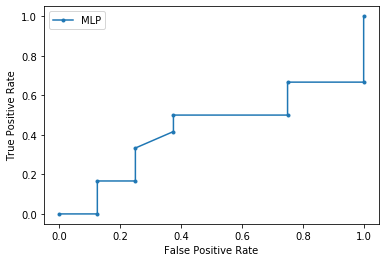

In [507]:
epochs = 10
p = runMLP(b,x_train,y_train,x_val,y_val)

Training  CNN
(78, 7, 3, 1)
Train on 78 samples
Epoch 1/10
78/78 [==============================] - 1s 9ms/sample - loss: 0.6938 - accuracy: 0.4872
Epoch 2/10
78/78 [==============================] - 0s 179us/sample - loss: 0.6911 - accuracy: 0.5128
Epoch 3/10
78/78 [==============================] - 0s 128us/sample - loss: 0.6912 - accuracy: 0.5256
Epoch 4/10
78/78 [==============================] - 0s 217us/sample - loss: 0.6895 - accuracy: 0.5256
Epoch 5/10
78/78 [==============================] - 0s 166us/sample - loss: 0.6887 - accuracy: 0.5256
Epoch 6/10
78/78 [==============================] - 0s 179us/sample - loss: 0.6883 - accuracy: 0.5256
Epoch 7/10
78/78 [==============================] - 0s 153us/sample - loss: 0.6881 - accuracy: 0.5256
Epoch 8/10
78/78 [==============================] - 0s 154us/sample - loss: 0.6880 - accuracy: 0.5256
Epoch 9/10
78/78 [==============================] - 0s 141us/sample - loss: 0.6876 - accuracy: 0.5256
Epoch 10/10
78/78 [=================

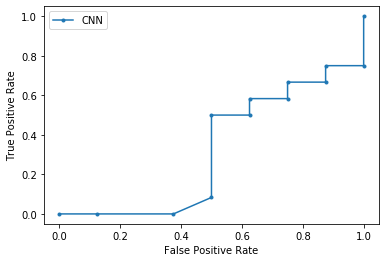

In [508]:
runCNN(b,x_train,y_train,x_val,y_val)

Training  sequential_4
(78, 21, 1)
Train on 78 samples
Epoch 1/10
78/78 [==============================] - 1s 18ms/sample - loss: 0.6872 - accuracy: 0.5128
Epoch 2/10
78/78 [==============================] - 0s 307us/sample - loss: 0.6839 - accuracy: 0.5385
Epoch 3/10
78/78 [==============================] - 0s 384us/sample - loss: 0.6825 - accuracy: 0.5128
Epoch 4/10
78/78 [==============================] - 0s 358us/sample - loss: 0.6817 - accuracy: 0.5256
Epoch 5/10
78/78 [==============================] - 0s 345us/sample - loss: 0.6805 - accuracy: 0.5769
Epoch 6/10
78/78 [==============================] - 0s 320us/sample - loss: 0.6807 - accuracy: 0.5256
Epoch 7/10
78/78 [==============================] - 0s 358us/sample - loss: 0.6786 - accuracy: 0.5385
Epoch 8/10
78/78 [==============================] - 0s 332us/sample - loss: 0.6778 - accuracy: 0.5128
Epoch 9/10
78/78 [==============================] - 0s 416us/sample - loss: 0.6772 - accuracy: 0.5128
Epoch 10/10
78/78 [=========

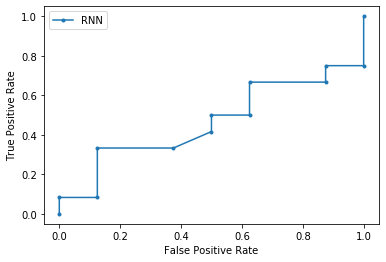

In [509]:
runRNN(b,x_train,y_train,x_val,y_val)

Training  GRU
(78, 21, 1)
Train on 78 samples
Epoch 1/10
78/78 [==============================] - 5s 58ms/sample - loss: 0.6936 - accuracy: 0.4231
Epoch 2/10
78/78 [==============================] - 0s 690us/sample - loss: 0.6924 - accuracy: 0.5128
Epoch 3/10
78/78 [==============================] - 0s 601us/sample - loss: 0.6919 - accuracy: 0.5256
Epoch 4/10
78/78 [==============================] - 0s 550us/sample - loss: 0.6917 - accuracy: 0.5256
Epoch 5/10
78/78 [==============================] - 0s 550us/sample - loss: 0.6917 - accuracy: 0.5256
Epoch 6/10
78/78 [==============================] - 0s 614us/sample - loss: 0.6915 - accuracy: 0.5256
Epoch 7/10
78/78 [==============================] - 0s 653us/sample - loss: 0.6914 - accuracy: 0.5256
Epoch 8/10
78/78 [==============================] - 0s 486us/sample - loss: 0.6914 - accuracy: 0.5256
Epoch 9/10
78/78 [==============================] - 0s 524us/sample - loss: 0.6916 - accuracy: 0.5256
Epoch 10/10
78/78 [==================

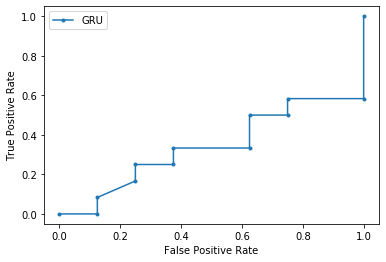

In [510]:
runGRU(b,x_train,y_train,x_val,y_val)

Training  LSTM
(78, 21, 1)
Train on 78 samples
Epoch 1/10
78/78 [==============================] - 3s 38ms/sample - loss: 0.6938 - accuracy: 0.5128
Epoch 2/10
78/78 [==============================] - 0s 678us/sample - loss: 0.6931 - accuracy: 0.4487
Epoch 3/10
78/78 [==============================] - 0s 511us/sample - loss: 0.6928 - accuracy: 0.5385
Epoch 4/10
78/78 [==============================] - 0s 499us/sample - loss: 0.6925 - accuracy: 0.5385
Epoch 5/10
78/78 [==============================] - 0s 537us/sample - loss: 0.6921 - accuracy: 0.5256
Epoch 6/10
78/78 [==============================] - 0s 499us/sample - loss: 0.6918 - accuracy: 0.5256
Epoch 7/10
78/78 [==============================] - 0s 550us/sample - loss: 0.6920 - accuracy: 0.5256
Epoch 8/10
78/78 [==============================] - 0s 511us/sample - loss: 0.6915 - accuracy: 0.5256
Epoch 9/10
78/78 [==============================] - 0s 588us/sample - loss: 0.6915 - accuracy: 0.5256
Epoch 10/10
78/78 [=================

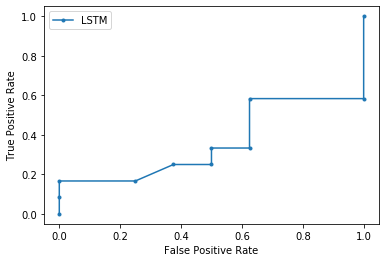

In [511]:
runLSTM(b,x_train,y_train,x_val,y_val)

Training  AttentionGRU
(78, 21, 1)
Train on 78 samples
Epoch 1/10
78/78 [==============================] - 3s 43ms/sample - loss: 2.3839 - accuracy: 0.6026
Epoch 2/10
78/78 [==============================] - 0s 703us/sample - loss: 2.2590 - accuracy: 0.5000
Epoch 3/10
78/78 [==============================] - 0s 588us/sample - loss: 2.1838 - accuracy: 0.4744
Epoch 4/10
78/78 [==============================] - 0s 588us/sample - loss: 2.0884 - accuracy: 0.4744
Epoch 5/10
78/78 [==============================] - 0s 549us/sample - loss: 2.0491 - accuracy: 0.4744
Epoch 6/10
78/78 [==============================] - 0s 626us/sample - loss: 1.8982 - accuracy: 0.4744
Epoch 7/10
78/78 [==============================] - 0s 652us/sample - loss: 1.9035 - accuracy: 0.4744
Epoch 8/10
78/78 [==============================] - 0s 511us/sample - loss: 1.8457 - accuracy: 0.4744
Epoch 9/10
78/78 [==============================] - 0s 550us/sample - loss: 1.7443 - accuracy: 0.4744
Epoch 10/10
78/78 [=========

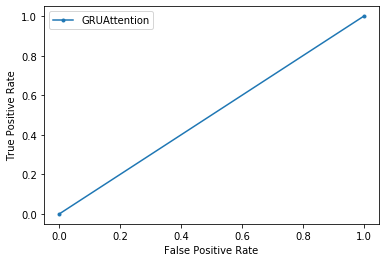

In [512]:
runGRUAttention(b,x_train,y_train,x_val,y_val)